カーネル法を用いたサポートベクタマシン
-------------------------
- 線形サポートベクタマシンを拡張し、より複雑なモデルを可能としたもの
- クラス分類にも回帰にも利用できる

In [1]:
from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from cycler import cycler
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

線形モデルと非線形特徴量
--------------------
- 低次元における線形モデルは非常に制約がつよい
    - 直線や超平面が柔軟性を制限するため
    - (直線で表現できる特徴量は2つで、直線だけで分類するのは難しい)
- 線形モデルを柔軟にする方法の一つが「特徴量を追加する」こと

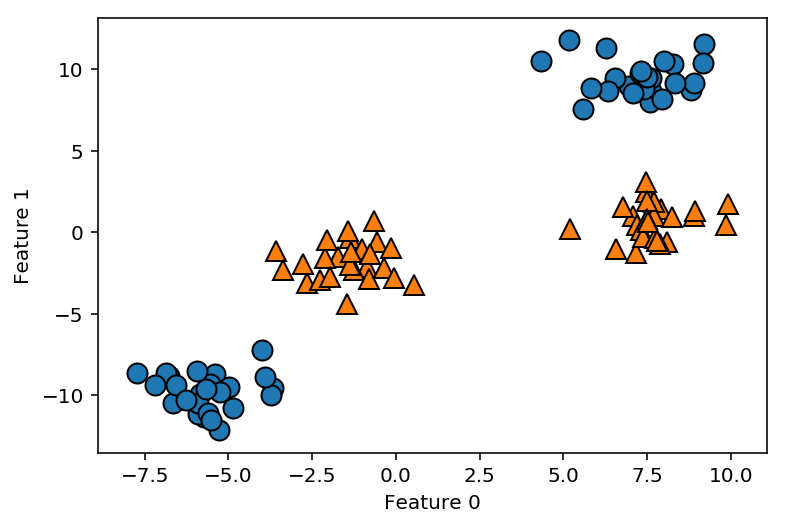

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, random_state=8)
y = y %2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

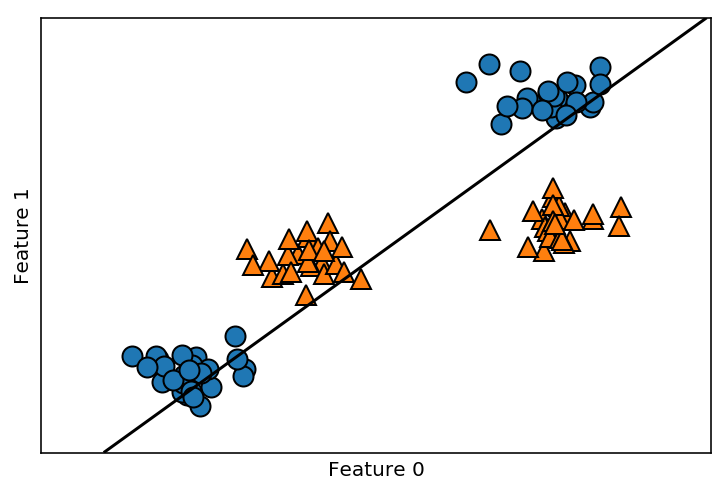

In [3]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

- 線形モデルによるクラス分類では、直線で分離することしかできないため、このようなデータセットではうまくいかない

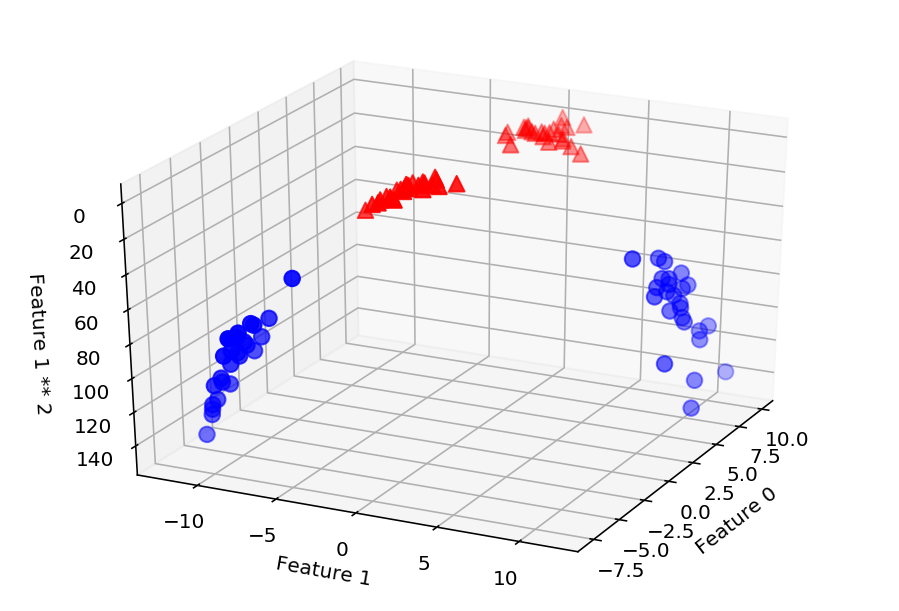

In [4]:
# 2番目の特徴量の2乗を追加
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

# 3dで可視化
ax = Axes3D(figure, elev=-152, azim=-26)
# y == 0の点をプロットしてから y==1の点をプロット
mask = y == 0
ax.scatter(X_new[mask,  0], X_new[mask,  1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask,  0], X_new[~mask,  1], X_new[~mask, 2], c='r', cmap=mglearn.cm2, marker='^', s=60)

ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.set_zlabel("Feature 1 ** 2")

- 特徴量を拡張する
- 例えば feature1 ** 2 つまり2番目の特徴量の2乗を新しい特徴量として追加してみる

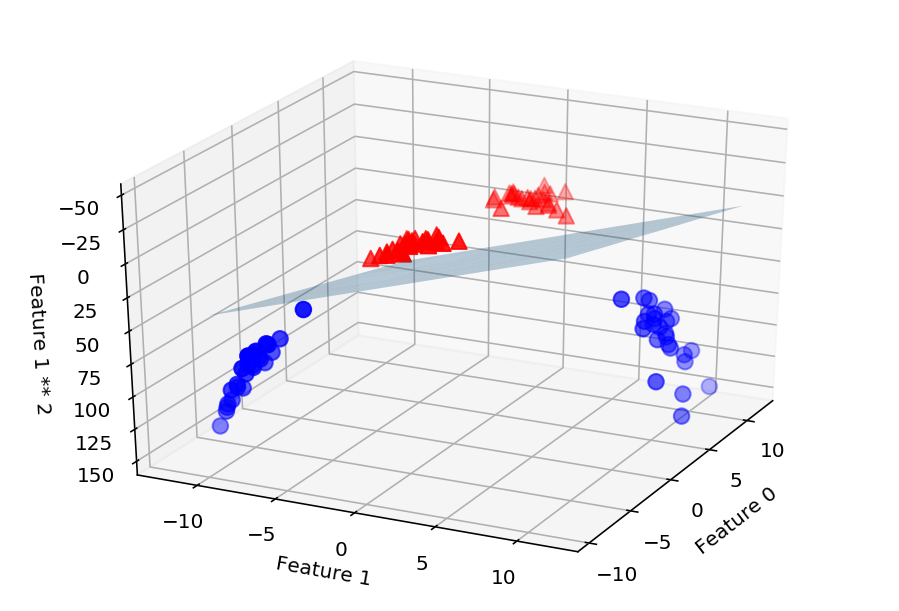

In [5]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 線形決定境界を描画
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)

ax.scatter(X_new[mask,  0], X_new[mask,  1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask,  0], X_new[~mask,  1], X_new[~mask, 2], c='r', cmap=mglearn.cm2, marker='^', s=60)

ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.set_zlabel("Feature 1 ** 2")

- この新しい表現では2つのクラスを線形モデルで、つまり３次元空間内の平面を用いて分離することが可能

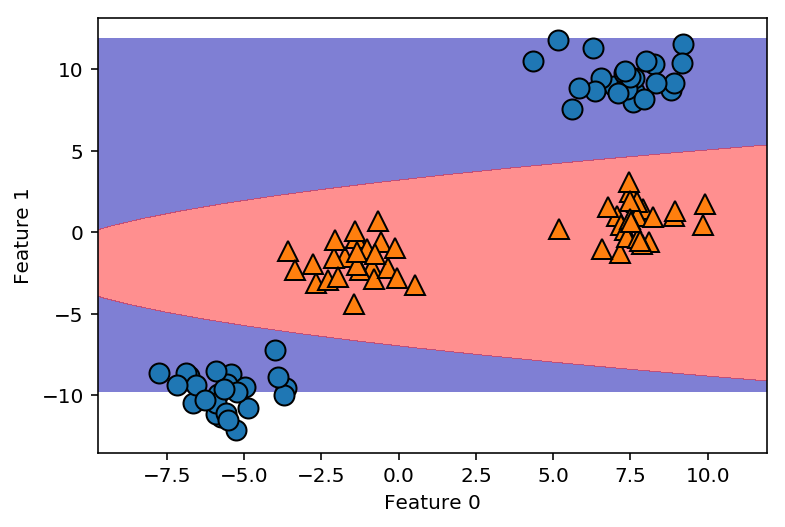

In [6]:
ZZ = YY ** 2
# 一次元で表現
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

- もとの特徴量の関数として見ると線形SVMモデルは線形ではなくなっている
- 直線ではなく楕円に近くなっている

### カーネルトリック
- 非線形の特徴量をデータ表現に加えることで線形モデルがはるかに強力になる
- しかし、実際にはどの特徴量を加えたらよいかわからない
    - たくさんの特徴量を加えると計算量が多すぎる
- これを解決するために、非常に大きくなりうる表現を実際には計算せずに高次元空間でのクラス分類機を学習させる数学的トリックが存在する。これを「カーネルトリック(kernel trick)」という
- サポートベクタマシンで広く用いられている高次元空間へのマップ方法は2つある
    - 1.もとの特徴量の特定の次数までの全ての多項式(feature1 ** 2 * feature2 ** 5など)を計算する「多項式カーネル(polynomial kernel)」
    - 2.放射基底関数(radial basis function: RBF)カーネルともよばれる「ガウシアンカーネル」

### SVNの理解
- SVMは個々のデータポイントが2つのクラスの決定境界を表現するのにどの程度重要かを学習する
- 多くの場合2つのクラスの境界に位置するごく一部の訓練データポイントだけが決定境界を決定する
    - これらのデータポイントを「サポートベクタ(support vector)」と呼ぶ
- 新しデータポインタに対して予測を行う際に、サポートベクタとデータポインタとの距離が測定される
    - クラス分類はこのサポートベクタとの距離と訓練過程で学習された`個々のサポートベクタの重要性※`によって決定される
        - ※ SVCの`dual_coef_`属性に格納される

#### 2次元2クラス分類データセットに対してサポートベクタマシンを学習させた結果

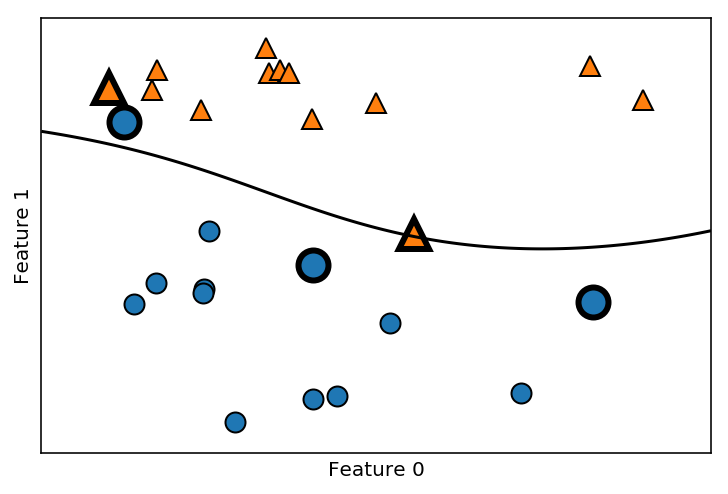

In [17]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# サポートベクタをプロットする
sv = svm.support_vectors_
# サポートベクタのクラスラベルはdual_coef_の正負によって与えられる
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

- この場合SVMによる境界は非線形(直線ではない)でありなめらか

### SVMのパラメータの調整
- gammmaパラメータはガウシアンカーネルの幅を調整する
    - このパラメータが点が近いということを意味するスケールを決定する
- Cパラメータは線形モデルで用いられたのと同様の正則化パラメタ
    - 個々のデータポイントの重要度(データポインタの`dual_coef_`)を制限する

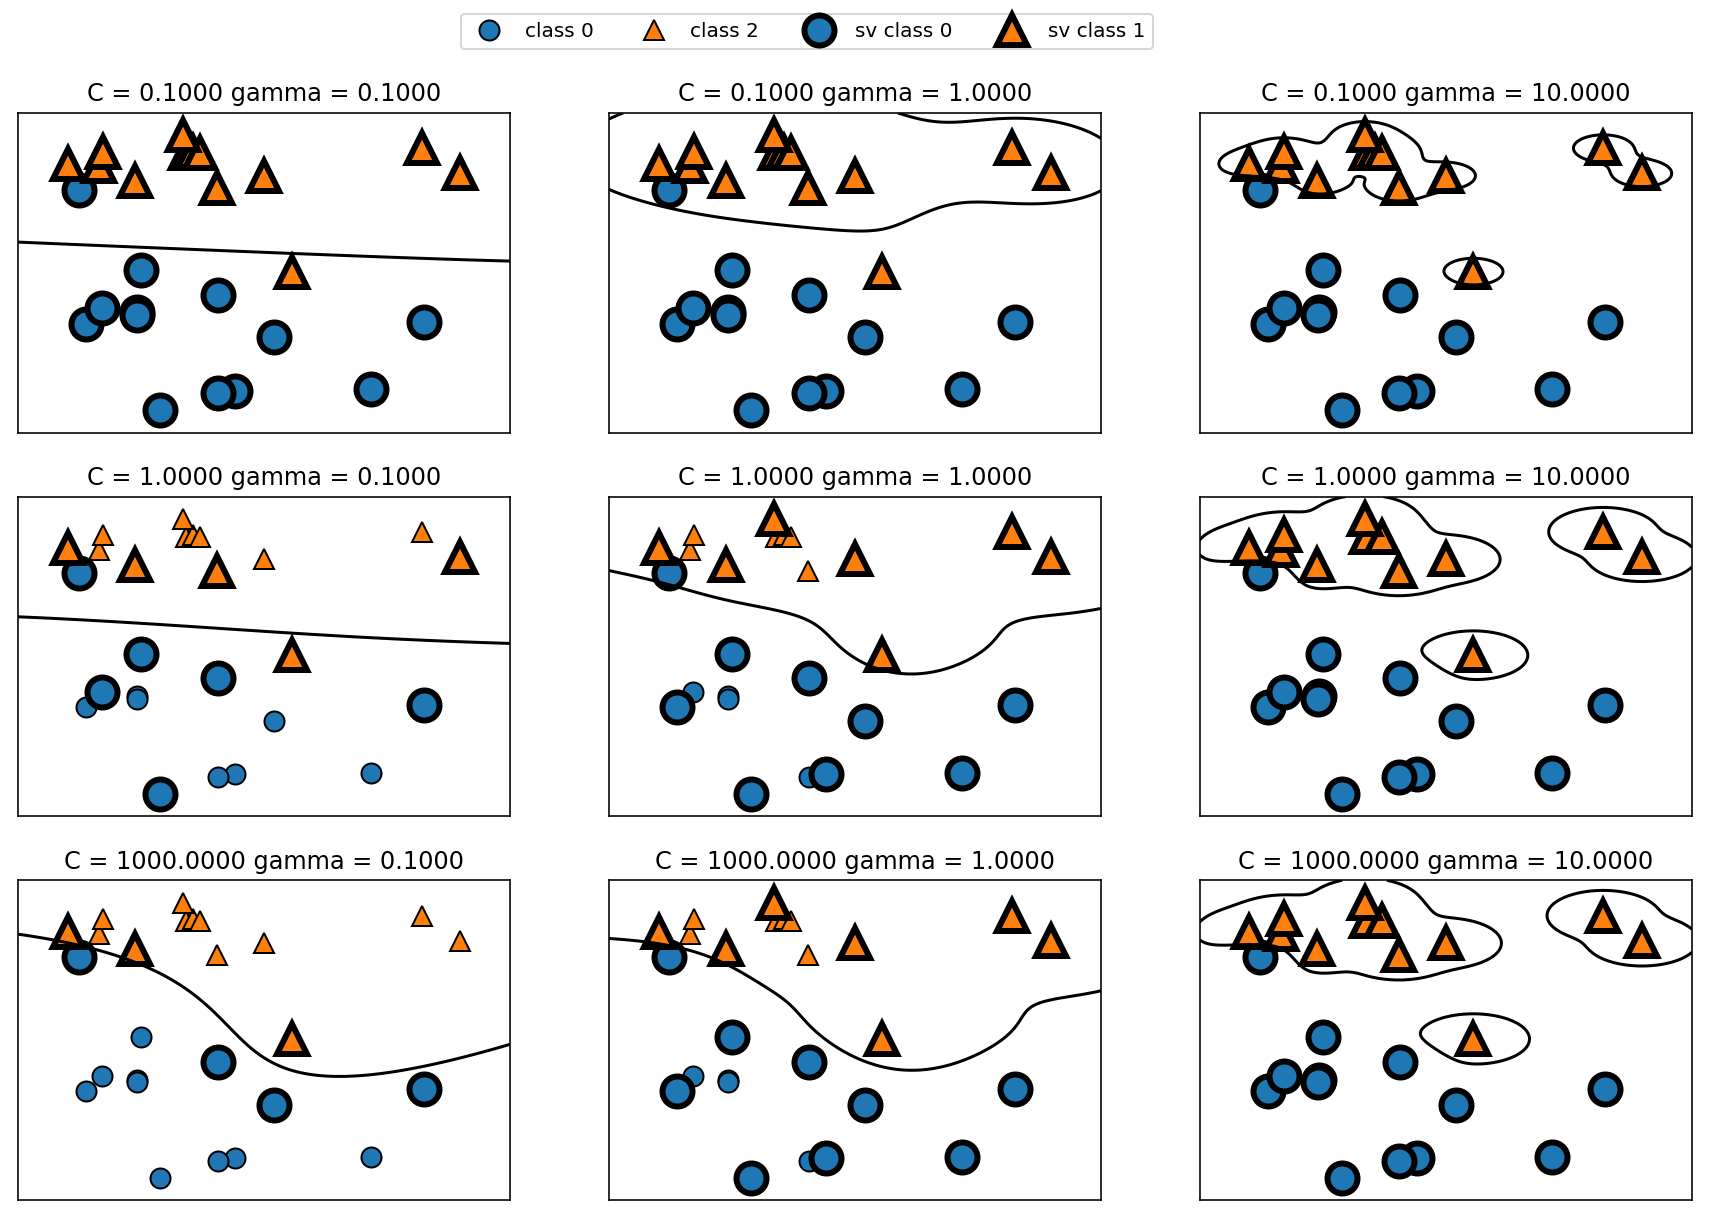

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

axes[0, 0].legend(["class 0", "class 2", "sv class 0", "sv class 1"], ncol=4, loc=(.9, 1.2))

#### 左から右へパラメタ`gamma`を0.1から10に変化させている
- gammaが小さいとガウシアンカーネルの直径が大きくなり多くの点を近いと判断するようになる
- これにより右に行くにつれて個々のデータポイントをより重要視するようになる
- gammaが小さい場合は決定境界はゆっくりとしか変化せずモデルの複雑さは小さくなる

#### 上から下にパラメタCを0.1から1000に変化させている
- 線形モデル同様に小さいCは制限されたモデルに対応し、個々のデータポイントの与える影響は限定される
- Cを大きくするとデータポイントがより強い影響をもつことになり、正しくクラス分類されるように決定境界を曲げている



### RBFカーネル法を用いたSVM

In [21]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.63


- 強く過剰適合している
- SVMはパラメータの設定とデータのスケールに敏感であるという問題がある
- 特に全ての特徴量の変位が同じスケールであることを要求する

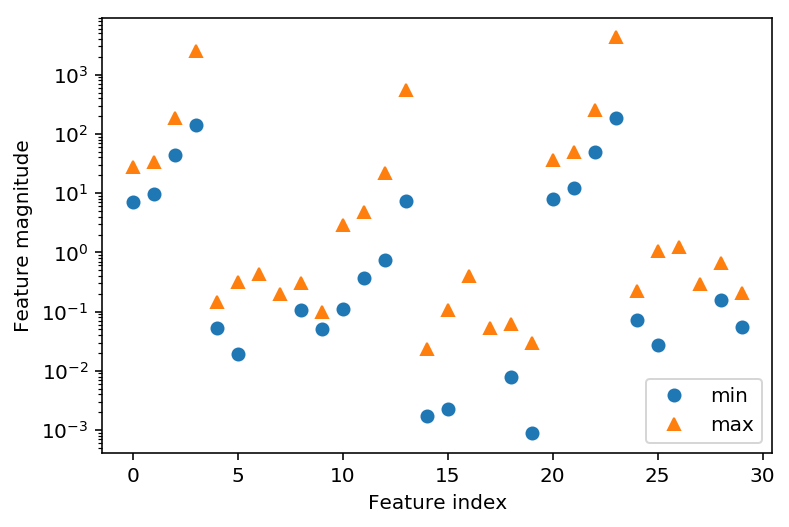

In [24]:
plt.plot(X_train.min(axis=0), 'o', label='min')
plt.plot(X_train.max(axis=0), '^', label='max')
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

- cancerデータセットの特徴量は相互に桁違いにサイズがことなる
- これは他のモデルでも問題になるが、カーネル法を用いたSVMでは破壊的な影響をもたらす

### SVMのためのデータの前処理
- 各特徴量のスケールがだいたい同じようになるようにそれぞれスケール変換を行う
- カーネル法を用いたSVMでよく使われる方法は全ての特徴量が0から1の間になるようにスケール変換する方法である

In [28]:
# 訓練セットの特徴量ごとに最小値を計算
min_on_training = X_train.min(axis=0)
# 訓練セットの特徴量ごとにレンジ(最大値 - 最小値)を計算
range_on_training = (X_train - min_on_training).max(axis=0)

# 最小値を引いてレンジで割る
# 個々の特徴量はmin=0, max=1となる
X_train_scaled = (X_train - min_on_training) / range_on_training
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n{}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [29]:
# テストセットに対しても同じ変換を行う
# 訓練セットの最小値とレンジを用いる
X_test_scaled = (X_test - min_on_training) / range_on_training

In [30]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set 0.948
Accuracy on test set 0.951


- テストの精度は一変した
- 現在は訓練セット精度とテストセットの精度が代替同じで100%からは遠いという適合不足の領域に入っている

In [31]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set 0.988
Accuracy on test set 0.972


- 上記を改善するためCを大きくすることにより精度は97.2まで向上した

### 利点
- カーネル法を用いたサポートベクタマシン(SVM)は様々なデータセットに対してうまく機能する強力なモデルである
- SVMを用いるとデータに僅かな特徴量しかない場合でも複雑な決定境界を生成することができる

### 欠点
- 低次元のデータでも高次元のデータでもうまく機能するがサンプルの個数が大きくなるとうまく機能しない
- SVMは10000サンプルぐらいまではうまく機能するが、100,000サンプルくらいになると、実行時やメモリ使用量の面でむずかしくなってくる
- 注意深くデータの前処理とパラメータ調整を行う必要がある
    - 今のところ多くのアプリケーションで勾配ブースティングなどのほとんど、または全く前処理が不要な決定木ベースのモデルのほうが用いられているのはこのため
- 検証が難しい

### ポイント
- 特徴量が似た測定器の測定結果(例えばカメラのピクセルなど)のように同じスケールになる場合はSVMを試してみる価値はある
- カーネル法を用いたSVMで重要なパラメータは「正則化パラメータC」とカーネルの選択、「カーネル固有のパラメタ」である
    - RBFカーネルではgamma